In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# loading R packages
library(plyr)
library(dplyr)
library(ggplot2)
library(tidyr)
library(phyloseq)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [4]:
%%R
physeq = import_biom("../data/otu_table_tax_no211_meta.biom", treefilename = "../data/ssu-aln.bacteria.mask.tre",
                    parseFunction = parse_taxonomy_greengenes)

In [5]:
%%R
l2fc<-read.csv("../data/l2fc.csv")

In [6]:
%%R
head(l2fc)

  Day Amdmt     OTU   baseMean        l2FC         SE    pvalue      padj
1   1     1  OTU.43  223.48048 -0.11012779 0.29052924 0.7046439 0.8990732
2   1     1   OTU.2 1664.01427  0.11095267 0.07837381 0.1568676 0.4569113
3   1     1 OTU.187  362.13258  0.06605159 0.15991481 0.6795756 0.8866206
4   1     1 OTU.150   39.05672  0.03205671 0.15816953 0.8393906 0.9496064
5   1     1  OTU.91   62.21140 -0.01718316 0.37497442 0.9634498 0.9886185
6   1     1 OTU.305   37.70726 -0.14629517 0.27103038 0.5893528 0.8405491


In [7]:
%%R
l2fc %>%
    group_by(OTU, Amdmt, Day) %>%
    summarize(N = n()) %>%
    arrange(desc(N)) %>%
    group_by() %>%
    head

Source: local data frame [6 x 4]

     OTU Amdmt Day N
1  OTU.1     1   1 1
2  OTU.1     1   2 1
3  OTU.1     2   1 1
4  OTU.1     2   2 1
5 OTU.10     1   1 1
6 OTU.10     1   2 1


In [8]:
%%R
d.plot = l2fc %>%
    select(OTU, Amdmt, Day, l2FC) %>%
    spread(Amdmt, l2FC)

In [9]:
%%R
colnames(d.plot) = c("OTU","Day","PyOM","Stover")

In [10]:
%%R
head(d.plot)

      OTU Day       PyOM     Stover
1   OTU.1   1  0.2054216  0.4771340
2   OTU.1   2 -0.1233362 -0.6062826
3  OTU.10   1  0.4884018  1.3051067
4  OTU.10   2  0.5907783  1.0979431
5 OTU.100   1  0.1624993  3.8479241
6 OTU.100   2 -0.3753782  0.6210347


In [11]:
%%R
pcollector1 = function (Day,OTU,PyOM){
    l2fc[l2fc$Day==Day & l2fc$OTU==OTU & l2fc$Amdmt==1,]$padj
}
pcollector2 = function (Day,OTU,Stover){
    l2fc[l2fc$Day==Day & l2fc$OTU==OTU & l2fc$Amdmt==2,]$padj
}
# Creating the functions to grab the adjusted p values, based on each day and OTUs

In [12]:
%%R
d.narm=d.plot[complete.cases(d.plot),]
dim(d.narm)
#Getting rid of the NAs, because that made the functions get confused.

[1] 7069    4


In [13]:
%%R
d.narm<-ddply(d.narm,c("Day","OTU"),transform, padjPyOM=pcollector1(Day,OTU),padjStover=pcollector2(Day,OTU))
head(d.narm)

       OTU Day        PyOM     Stover  padjPyOM   padjStover
1    OTU.1   1  0.20542160  0.4771340 0.5709752 1.720374e-01
2   OTU.10   1  0.48840184  1.3051067 0.1341594 5.782691e-06
3  OTU.100   1  0.16249933  3.8479241 0.8659611 1.648816e-11
4 OTU.1000   1 -0.05912125 -0.6842893 0.9293053 2.937055e-01
5 OTU.1001   1 -0.42946608 -1.1873493 0.5760887 2.117950e-01
6 OTU.1002   1 -0.18209508 -1.2019310 0.7622668 2.447503e-02


In [14]:
%%R
d.narm$pprod<-d.narm$padjPyOM*d.narm$padjStover

In [15]:
%%R
taxa<-data.frame(subset_taxa(tax_table(physeq)))
taxa$OTU<-row.names(taxa)
head(taxa)

          Kingdom         Phylum               Class              Order
OTU.3919 Bacteria Actinobacteria       Rubrobacteria    Rubrobacterales
OTU.3038 Bacteria Proteobacteria Deltaproteobacteria [Entotheonellales]
OTU.2120 Bacteria Proteobacteria Deltaproteobacteria [Entotheonellales]
OTU.679  Bacteria Proteobacteria Deltaproteobacteria [Entotheonellales]
OTU.6355 Bacteria  Acidobacteria              iii1-8              32-20
OTU.299  Bacteria  Acidobacteria              iii1-8              32-20
                      Family Genus Species Rank1      OTU
OTU.3919    Rubrobacteraceae  <NA>    <NA>  <NA> OTU.3919
OTU.3038 [Entotheonellaceae]  <NA>    <NA>  <NA> OTU.3038
OTU.2120 [Entotheonellaceae]  <NA>    <NA>  <NA> OTU.2120
OTU.679  [Entotheonellaceae]  <NA>    <NA>  <NA>  OTU.679
OTU.6355                <NA>  <NA>    <NA>  <NA> OTU.6355
OTU.299                 <NA>  <NA>    <NA>  <NA>  OTU.299


In [16]:
%%R
taxonomycollector = function (OTU){
    taxa[taxa$OTU==OTU,1:8]
}

# Creating the functions to grab the taxonomy, based on each day and OTUs

In [17]:
%%R
d.narm.tax<-ddply(d.narm,"OTU",transform, taxonomy=taxonomycollector(OTU))
head(d.narm.tax)

      OTU Day       PyOM     Stover     padjPyOM   padjStover        pprod
1   OTU.1   1  0.2054216  0.4771340 0.5709752473 1.720374e-01 9.822909e-02
2   OTU.1   2 -0.1233362 -0.6062826 0.6511155845 1.987838e-04 1.294312e-04
3  OTU.10   1  0.4884018  1.3051067 0.1341593959 5.782691e-06 7.758024e-07
4  OTU.10   2  0.5907783  1.0979431 0.0003493384 6.731538e-08 2.351585e-11
5 OTU.100   1  0.1624993  3.8479241 0.8659610526 1.648816e-11 1.427811e-11
6 OTU.100   2 -0.3753782  0.6210347 0.3029378494 1.077858e-01 3.265239e-02
  taxonomy.Kingdom taxonomy.Phylum      taxonomy.Class   taxonomy.Order
1         Bacteria  Proteobacteria Alphaproteobacteria Sphingomonadales
2         Bacteria  Proteobacteria Alphaproteobacteria Sphingomonadales
3         Bacteria  Actinobacteria      Actinobacteria  Actinomycetales
4         Bacteria  Actinobacteria      Actinobacteria  Actinomycetales
5         Bacteria  Proteobacteria Alphaproteobacteria Sphingomonadales
6         Bacteria  Proteobacteria Alphapro

In [18]:
%%R
D <- d.narm.tax
sums<-ddply(D,"taxonomy.Phylum",summarize,sum=length(taxonomy.Phylum))
remove<-sums$taxonomy.Phylum[sums$sum<=10]

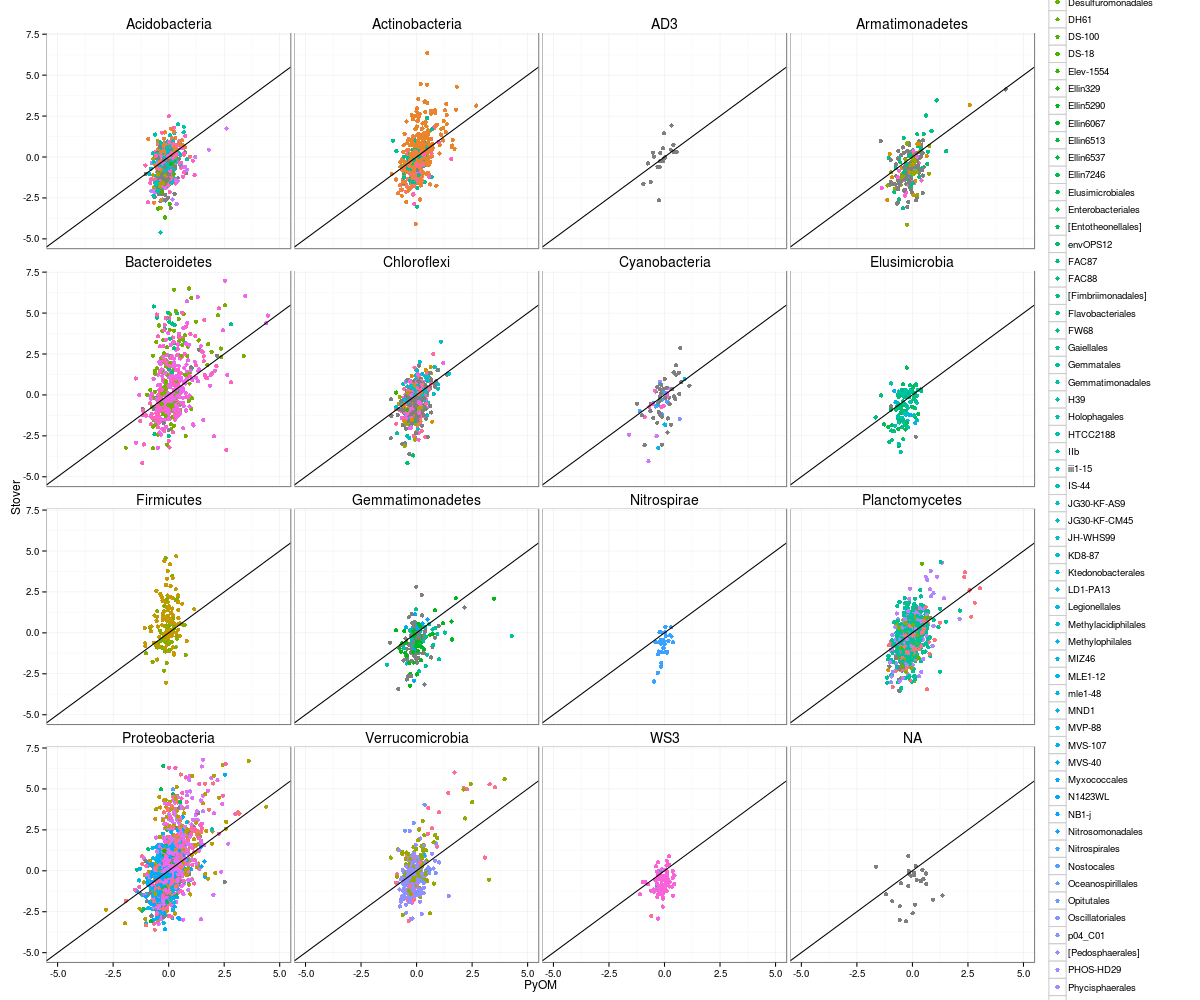

In [34]:
%%R -h 1000 -w 1200
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax
mintaxa<-20
sums<-ddply(D,"taxonomy.Phylum",summarize,sum=length(taxonomy.Phylum))
remove<-sums$taxonomy.Phylum[sums$sum<=mintaxa]
D2<-D[!(D$taxonomy.Phylum %in% remove),]
D2$taxonomy.Phylum<-factor(D2$taxonomy.Phylum)
# Removing the rare phyla

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=taxonomy.Order))
p = p + geom_point()
p = p + geom_abline(slope = 1, intercept = 0)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~taxonomy.Phylum, ncol=4)
p = p + scale_x_continuous(limits = c(-5, 5)) + scale_y_continuous(limits = c(-5, 7))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p

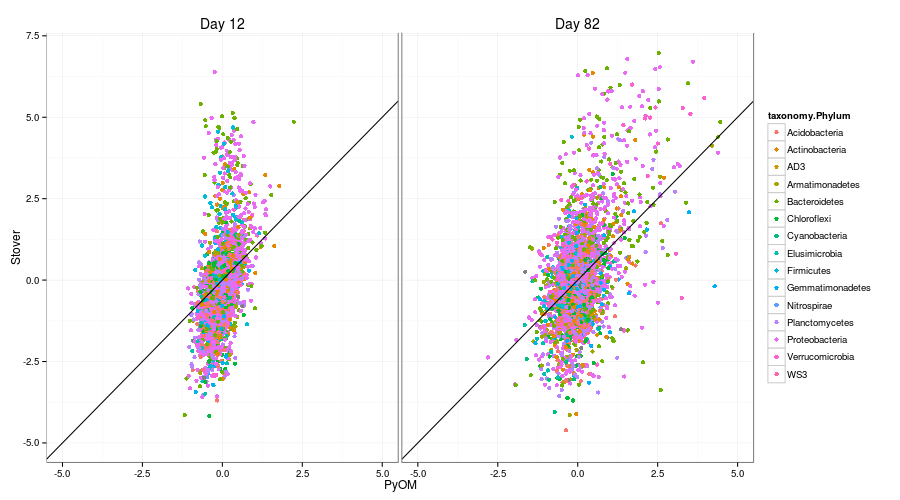

In [33]:
%%R -h 500 -w 900
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax
mintaxa<-20
sums<-ddply(D,"taxonomy.Phylum",summarize,sum=length(taxonomy.Phylum))
remove<-sums$taxonomy.Phylum[sums$sum<=mintaxa]
D2<-D[!(D$taxonomy.Phylum %in% remove),]
D2$taxonomy.Phylum<-factor(D2$taxonomy.Phylum)
# Removing the rare phyla

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=taxonomy.Phylum))
p = p + geom_point()
p = p + geom_abline(slope = 1, intercept = 0)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~DayName, ncol=2)
p = p + scale_x_continuous(limits = c(-5, 5)) + scale_y_continuous(limits = c(-5, 7))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p

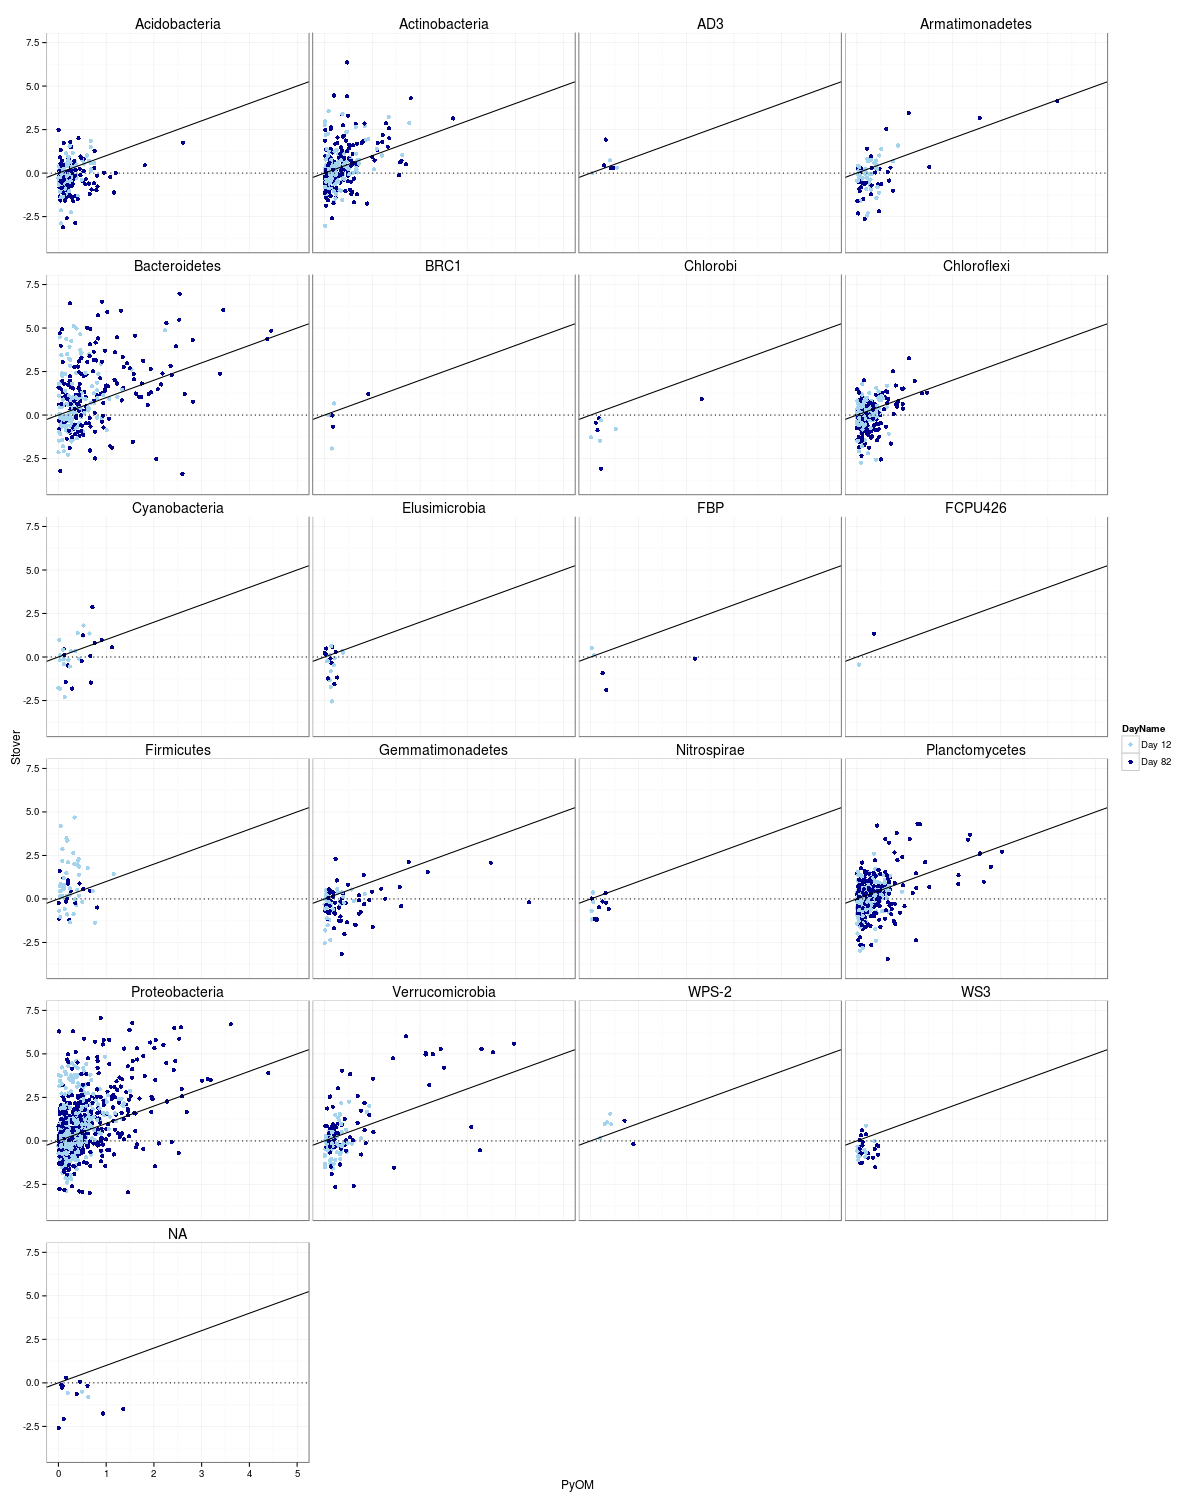

In [19]:
%%R -h 1500 -w 1200
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax
mintaxa<-10
sums<-ddply(D,"taxonomy.Phylum",summarize,sum=length(taxonomy.Phylum))
remove<-sums$taxonomy.Phylum[sums$sum<=mintaxa]
D2<-D[!(D$taxonomy.Phylum %in% remove),]
D2$taxonomy.Phylum<-factor(D2$taxonomy.Phylum)
# Removing the rare phyla

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=DayName))
p = p + geom_point()
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~taxonomy.Phylum, ncol=4)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-4, 7.5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p = p + scale_colour_manual(values=c("lightskyblue2","blue4"))
# "orange","gold1","red3"

p

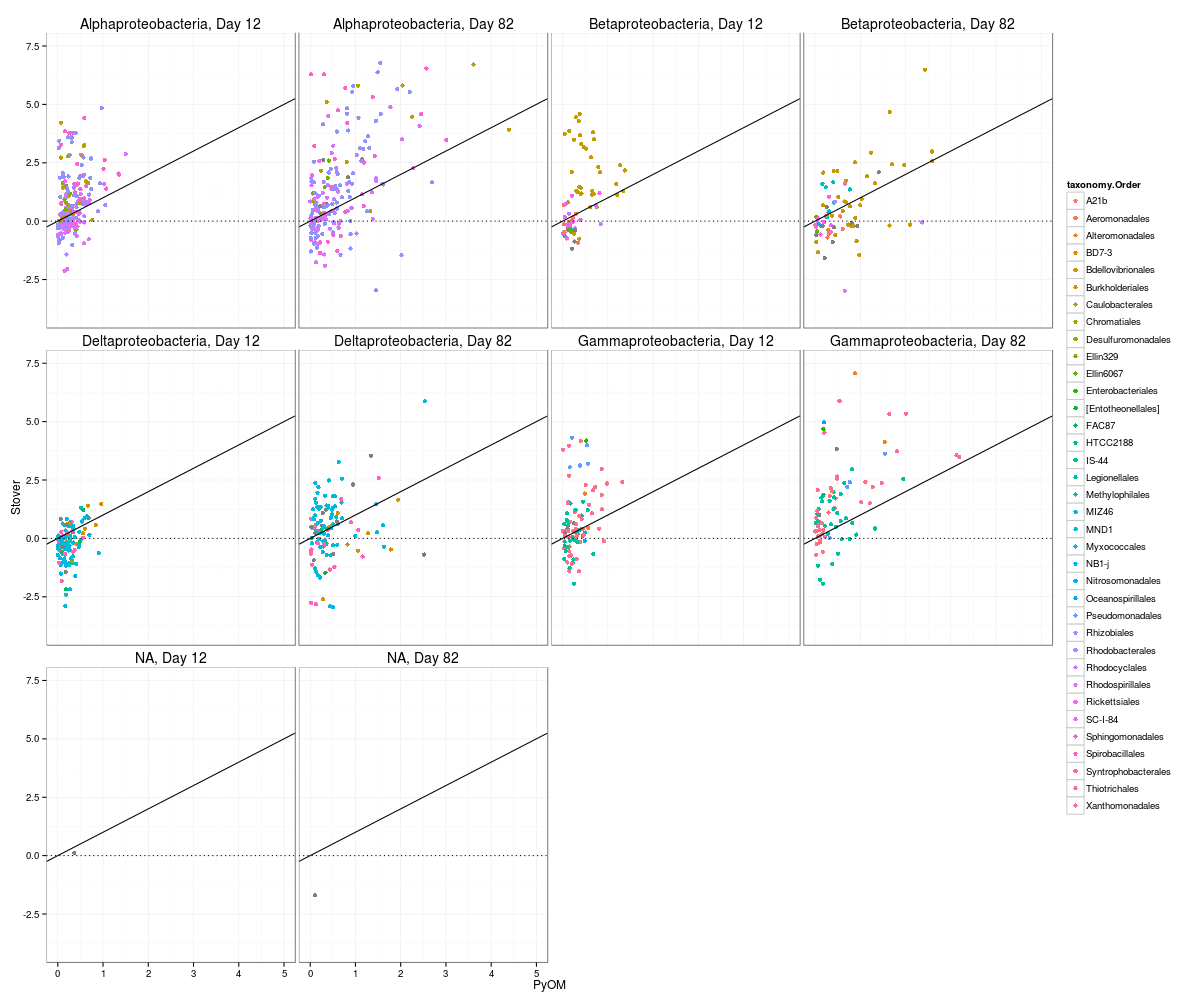

In [20]:
%%R -h 1000 -w 1200
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax
keep<-"Proteobacteria"
D2<-D[(D$taxonomy.Phylum %in% keep),]
D2$taxonomy.Phylum<-factor(D2$taxonomy.Phylum)
# Selecting the phylum

mintaxa<-10
sums<-ddply(D2,"taxonomy.Class",summarize,sum=length(taxonomy.Class))
remove<-sums$taxonomy.Class[sums$sum<=mintaxa]
D2<-D2[!(D2$taxonomy.Class %in% remove),]
D2$taxonomy.Class<-factor(D2$taxonomy.Class)
# Removing rare orders

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=taxonomy.Order))
p = p + geom_point()
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~taxonomy.Class~DayName, ncol=4)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-4, 7.5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p

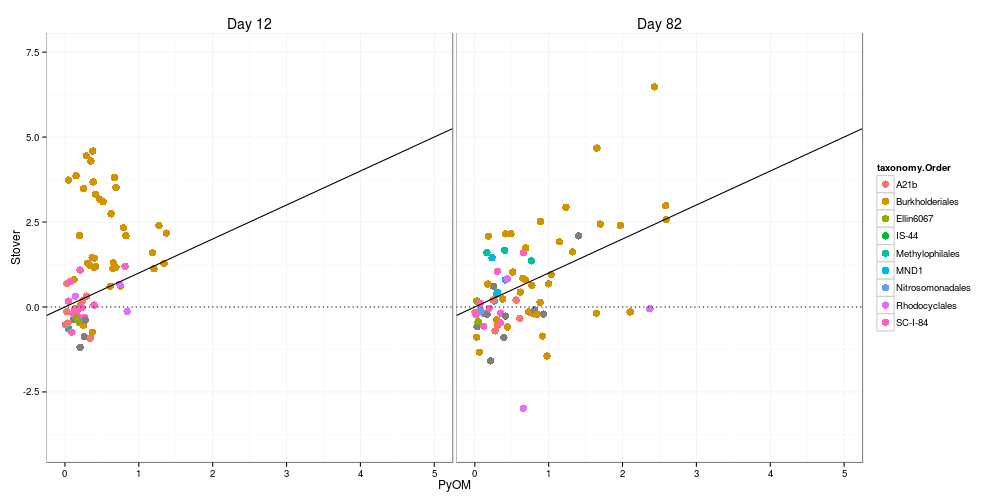

In [38]:
%%R -h 500 -w 1000
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax
keep<-"Proteobacteria"
D2<-D[(D$taxonomy.Phylum %in% keep),]
D2$taxonomy.Phylum<-factor(D2$taxonomy.Phylum)
# Selecting the phylum

D <- d.narm.tax
keep<-"Betaproteobacteria"
D2<-D[(D$taxonomy.Class %in% keep),]
D2$taxonomy.Class<-factor(D2$taxonomy.Class)
# Selecting the class

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=taxonomy.Order))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
p = p + facet_wrap(~DayName, ncol=2)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-4, 7.5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p

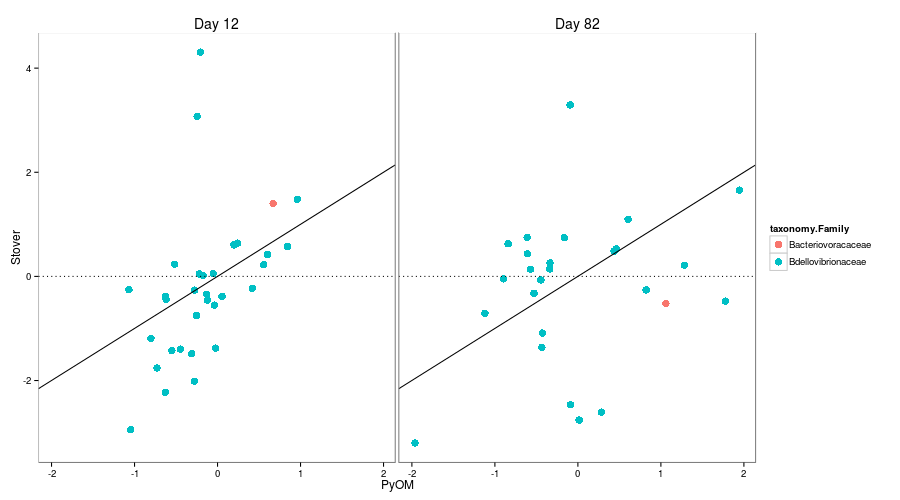

In [41]:
%%R -h 500 -w 900

D <- d.narm.tax
keep<-"Bdellovibrionales"
D2<-D[(D$taxonomy.Order %in% keep),]
D2$taxonomy.Order<-factor(D2$taxonomy.Order)
# Selecting the phylum


D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=taxonomy.Family))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
p = p + facet_wrap(~DayName, ncol=2)
# p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-4, 7.5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p


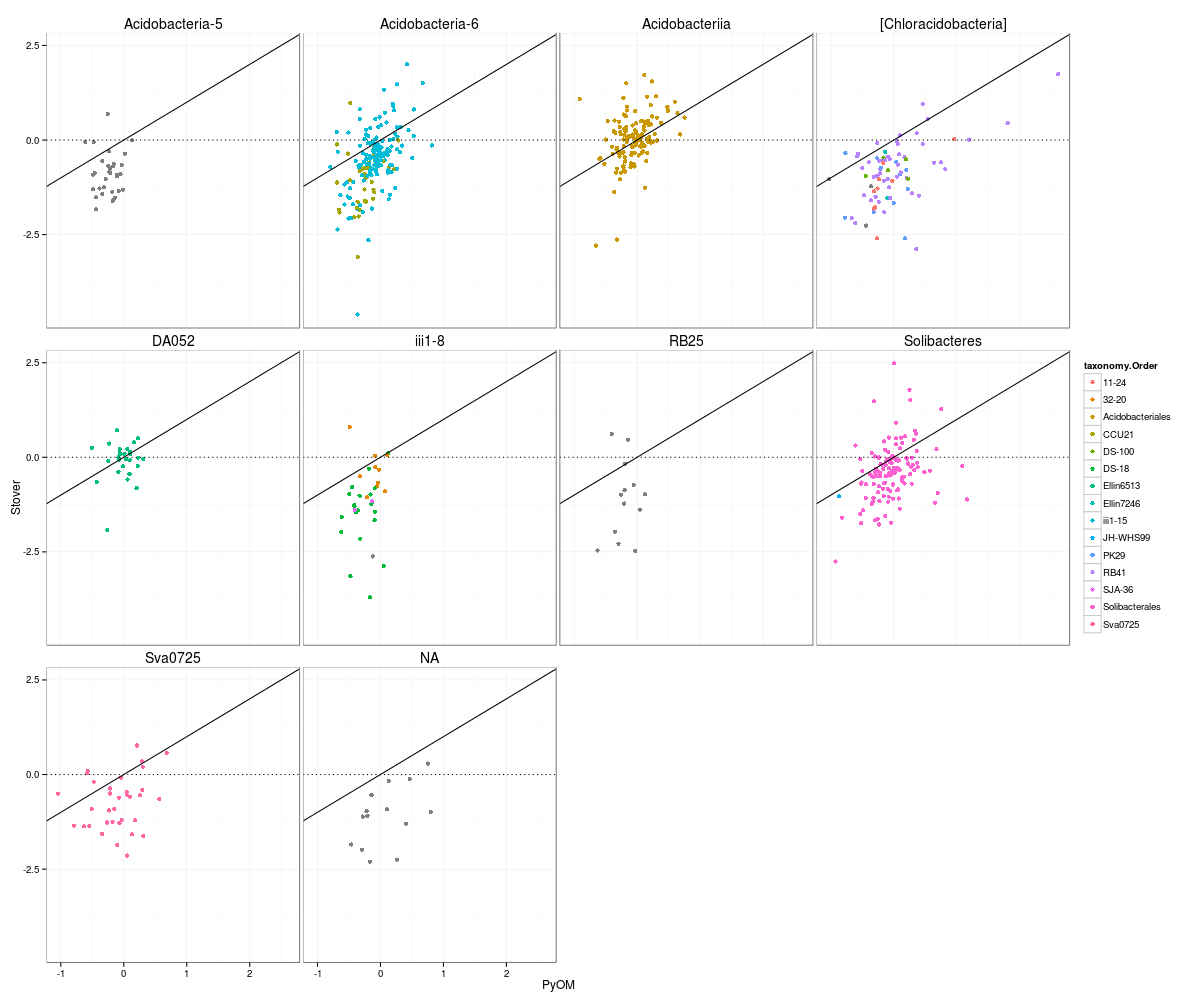

In [23]:
%%R -h 1000 -w 1200
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax
keep<-"Acidobacteria"
D2<-D[(D$taxonomy.Phylum %in% keep),]
D2$taxonomy.Phylum<-factor(D2$taxonomy.Phylum)
# Selecting the phylum

mintaxa<-10
sums<-ddply(D2,"taxonomy.Class",summarize,sum=length(taxonomy.Class))
remove<-sums$taxonomy.Class[sums$sum<=mintaxa]
D2<-D2[!(D2$taxonomy.Class %in% remove),]
D2$taxonomy.Class<-factor(D2$taxonomy.Class)
# Removing rare orders

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=taxonomy.Order))
p = p + geom_point()
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~taxonomy.Class, ncol=4)
#p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-4, 7.5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p

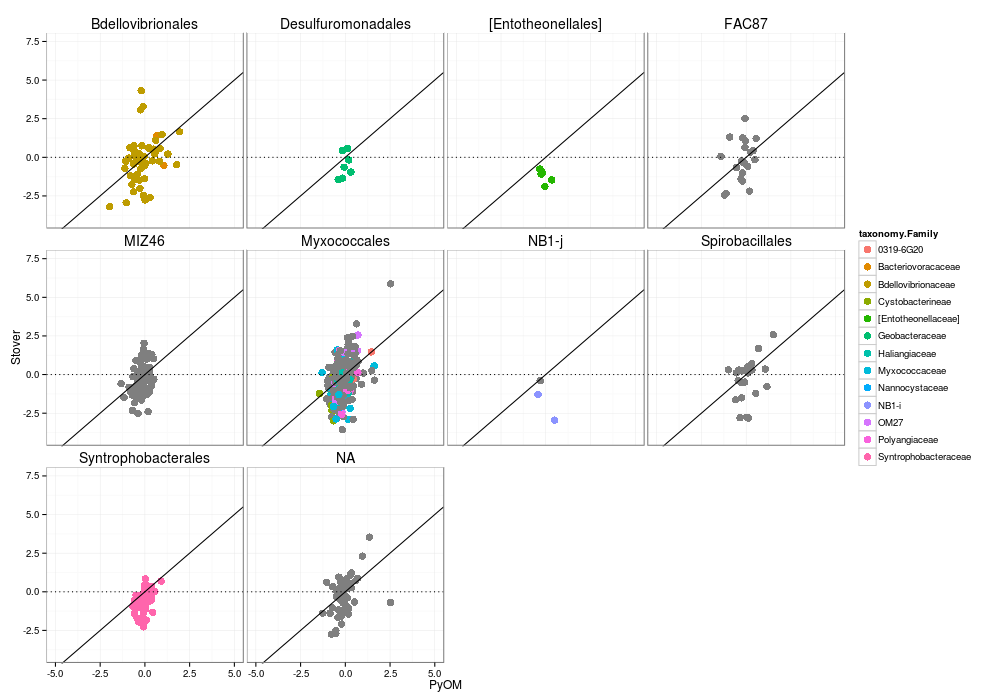

In [50]:
%%R -h 700 -w 1000
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax
keep<-"Deltaproteobacteria"
D2<-D[(D$taxonomy.Class %in% keep),]
D2$taxonomy.Class<-factor(D2$taxonomy.Class)
# Selecting the phylum


D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=taxonomy.Family))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~taxonomy.Order, ncol=4)
p = p + scale_x_continuous(limits = c(-5, 5)) + scale_y_continuous(limits = c(-4, 7.5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p

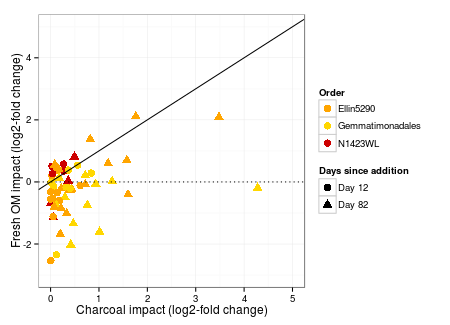

In [35]:
%%R -h 325 -w 450
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax
keep<-"Gemmatimonadetes"
D2<-D[(D$taxonomy.Phylum %in% keep),]
D2$taxonomy.Phylum<-factor(D2$taxonomy.Phylum)
# Selecting the phylum

mintaxa<-10
sums<-ddply(D2,"taxonomy.Order",summarize,sum=length(taxonomy.Order))
remove<-sums$taxonomy.Order[sums$sum<=mintaxa]
D2<-D2[!(D2$taxonomy.Order %in% remove),]
D2$taxonomy.Order<-factor(D2$taxonomy.Order)
# Removing rare orders

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=taxonomy.Order, shape=DayName))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
#p = p + facet_wrap(~taxonomy.Class~DayName, ncol=4)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-3, 5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p = p + scale_colour_manual(values=c("orange","gold1","red3"))
p = p + guides(colour = guide_legend("Order"), shape = guide_legend("Days since addition"))
p = p + labs(x="Charcoal impact (log2-fold change)", y="Fresh OM impact (log2-fold change)")


#ggsave(filename = "Gemmatimonadetes.pdf", plot = p, width=5, height = 3.5)
p

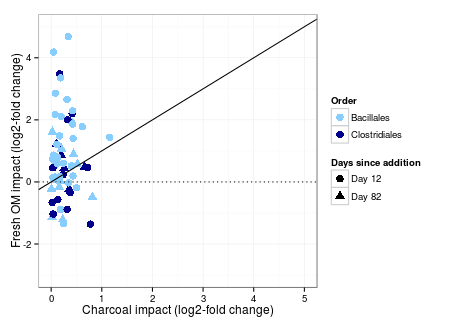

In [36]:
%%R -h 325 -w 450
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax
keep<-"Firmicutes"
D2<-D[(D$taxonomy.Phylum %in% keep),]
D2$taxonomy.Phylum<-factor(D2$taxonomy.Phylum)
# Selecting the phylum

mintaxa<-10
sums<-ddply(D2,"taxonomy.Class",summarize,sum=length(taxonomy.Class))
remove<-sums$taxonomy.Class[sums$sum<=mintaxa]
D2<-D2[!(D2$taxonomy.Class %in% remove),]
D2$taxonomy.Class<-factor(D2$taxonomy.Class)
# Removing rare orders

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=taxonomy.Order, shape=DayName))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
#p = p + facet_wrap(~taxonomy.Class~DayName, ncol=4)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-3, 5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p = p + scale_colour_manual(values=c("skyblue1","blue4"))
p = p + guides(colour = guide_legend("Order"), shape = guide_legend("Days since addition"))
p = p + labs(x="Charcoal impact (log2-fold change)", y="Fresh OM impact (log2-fold change)")

#ggsave(filename = "Firmicutes.pdf", plot = p, width=5, height = 3.5)
p

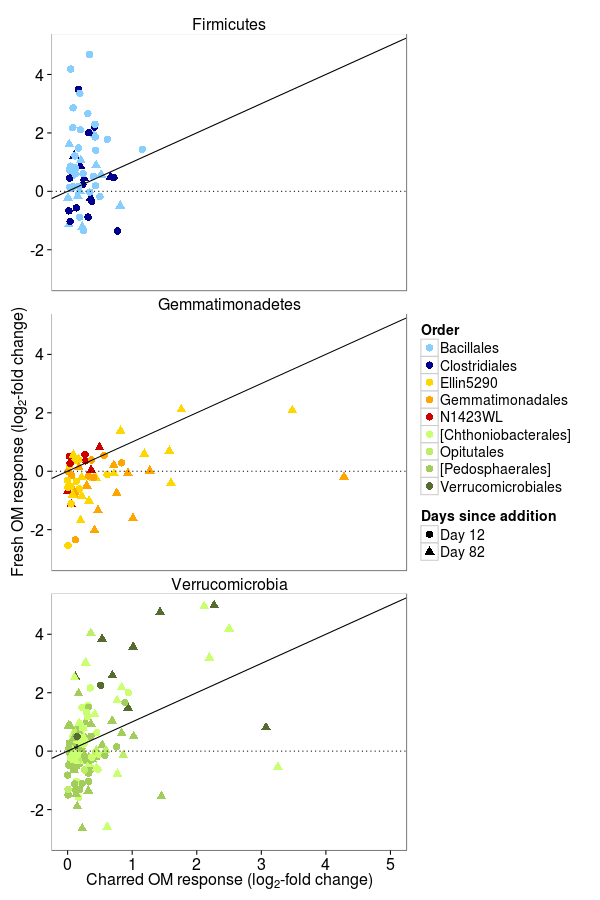

In [83]:
%%R -h 900 -w 600
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax
keep<-c("Gemmatimonadetes","Firmicutes","Verrucomicrobia")
D2<-D[(D$taxonomy.Phylum %in% keep),]
D2$taxonomy.Phylum<-factor(D2$taxonomy.Phylum)
# Selecting the phylum

mintaxa<-5
sums<-ddply(D2,"taxonomy.Order",summarize,sum=length(taxonomy.Order))
remove<-sums$taxonomy.Order[sums$sum<=mintaxa]
D2<-D2[!(D2$taxonomy.Order %in% remove),]
D2$taxonomy.Order<-factor(D2$taxonomy.Order, levels=c("Bacillales","Clostridiales","Ellin5290","Gemmatimonadales","N1423WL","[Chthoniobacterales]","Opitutales","[Pedosphaerales]","Verrucomicrobiales"))
# Removing rare orders

D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=taxonomy.Order, shape=DayName))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~taxonomy.Phylum, ncol=1)
p = p + scale_x_continuous(limits = c(0, 5)) + scale_y_continuous(limits = c(-3, 5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.text.x = element_text(size = 16),
    axis.title.x = element_text(size = 16),
    axis.text.y = element_text(size=16),
    axis.title.y = element_text(size = 16),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 14)
  ) +
  theme(
      strip.text.x = element_text(size=16), 
      strip.background = element_rect(colour="white", fill="white")
  )

p = p + scale_colour_manual(values=c("skyblue1","blue4","gold1","orange","red3","darkolivegreen1","darkolivegreen2","darkolivegreen3","darkolivegreen"))
p = p + guides(colour = guide_legend("Order"), shape = guide_legend("Days since addition"))
p = p + labs(x=expression(paste("Charred OM response (", log[2],"-fold change)",sep="")), y=expression(paste("Fresh OM response (", log[2],"-fold change)",sep="")))

ggsave(filename = "Firmicutes+Gemmatimonadetes.pdf", plot = p, width=6, height = 8)
p

In [56]:
%%R
D <- d.narm.tax
keep<-c("OTU.873")
D2<-D[(D$OTU %in% keep),]
D2

         OTU Day     PyOM    Stover     padjPyOM   padjStover        pprod
6767 OTU.873   1 2.231887  4.863171 8.052159e-08 5.601384e-07 4.510324e-14
6768 OTU.873   2 1.060160 -0.199297 4.702186e-03 8.759505e-01 4.118882e-03
     taxonomy.Kingdom taxonomy.Phylum taxonomy.Class taxonomy.Order
6767         Bacteria   Bacteroidetes     Cytophagia   Cytophagales
6768         Bacteria   Bacteroidetes     Cytophagia   Cytophagales
     taxonomy.Family taxonomy.Genus taxonomy.Species taxonomy.Rank1
6767   Cytophagaceae   Hymenobacter             <NA>           <NA>
6768   Cytophagaceae   Hymenobacter             <NA>           <NA>


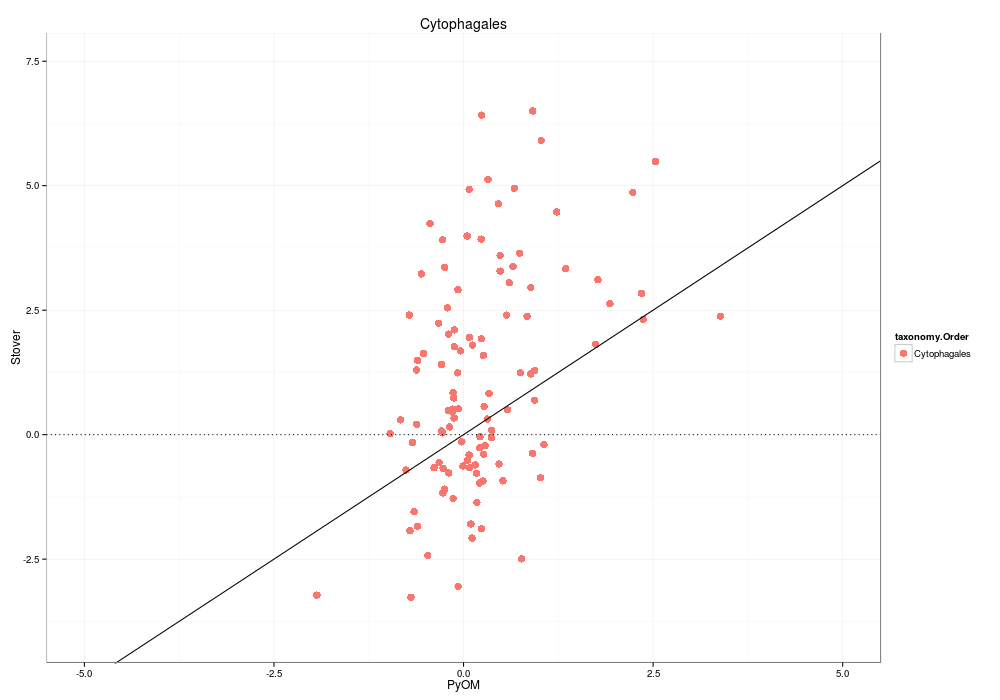

In [58]:
%%R -h 700 -w 1000
#p = ggplot(d.plot, aes(x = `1`, y =`2`))
D <- d.narm.tax
keep<-"Cytophagia"
D2<-D[(D$taxonomy.Class %in% keep),]
D2$taxonomy.Class<-factor(D2$taxonomy.Class)
# Selecting the phylum


D2$DayName = ifelse(D2$Day==1,"Day 12",ifelse(D2$Day==2,"Day 82","Day 1"))
p = ggplot(D2, aes(x = PyOM, y =Stover, color=taxonomy.Order))
p = p + geom_point(size=3.5)
p = p + geom_abline(slope = 1, intercept = 0)
p = p + geom_abline(slope = 0, intercept = 0, linetype=3)
# p = p + geom_abline(x=2)
# p = p + stat_smooth(method = "lm")
p = p + facet_wrap(~taxonomy.Order, ncol=4)
p = p + scale_x_continuous(limits = c(-5, 5)) + scale_y_continuous(limits = c(-4, 7.5))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   #,panel.grid.major = element_blank()
   #,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14), strip.background = element_rect(colour="white", fill="white"))
p